Ключевая суть данного алгоритма базируется на предположении, что наши граничные данные являются т.н. выбросами. 
Чтобы надлежащим образом удалить данные выбросы существует две техники: IQR (InterQuartile Range) и метод основанный на z-оценках. В данном примере мы рассмотрим оба подхода, а также сравним, какой из них показывает лучший результат.


Для начала импортируем все необходимые библиотеки, которые нам понадобятся в данном проекте.

In [3]:
import mne
from pymatreader import read_mat
import numpy as np
import pandas as pd
from scipy import stats

Теперь сформируем путь к файлу с данными fieldtrip и получим их с помощью функйии read_mat библиотеки pymatreader

In [6]:
data_folder = mne.datasets.sample.data_path('C:\Учеба\Аспирантура\Кандидатка\matlab_stuff')
data_raw_file = (data_folder / 'data.mat')
data = read_mat(data_raw_file)

Теперь получим данные для каждого экспериментуемого потриально. Всего у нас 13 подопытных, на каждого приходится не более 400
триалов с данными. Для каждого триала с лету вычислим дисперсию, так как именно эта метрика будет определять, какие триалы
мы считаем выбросами, а какие - нет. Дисперсия будет вычислена для каждого триала поканально, затем будет взята как среднее
поканальных дисперсий

In [73]:
trial_variance = list()
for data_frame in data['data']:
    patient_variance = list()
    for frame_trial in data_frame['trial']:
        trial_var_per_chanel = frame_trial.var(1)
        trial_var = np.mean(trial_var_per_chanel)
        patient_variance.append(trial_var)
    if(len(patient_variance) < 400):
        while(len(patient_variance) < 400):
            patient_variance.append(0)
    trial_variance.append(patient_variance)

Получив наши данные, начнем применять к ним различные способы удаления выбросов.

Первым способом будет IQR. В описательной статистике межквартильный диапазон,
также называемый средним или средним 50%, или технически H-разбросом, является мерой статистической дисперсии,
равной разнице между 75-м и 25-м процентилями или между верхним и нижним квартилями, IQR = Q₃ − Q₁.

Шаги для обнаружения выбросов путем определения нижней и верхней границ данных:
1. Расположите свои данные в порядке возрастания
2. Рассчитайте Q1 (первый квартал)
3. Рассчитайте Q3 (третий квартиль)
4. Найдите IQR = (Q3 - Q1)
5. Найдите нижний диапазон = Q1 - (1,5 * IQR)
6. Найдите верхний диапазон = Q3 + (1,5 * IQR)

Для начала сформируем DataFrame с помощью библиотеки pandas, чтобы облегчить себе работу:

In [167]:
trial_variance_array = np.array(trial_variance, dtype = float)
df_columns = ['Patient ' + str(patient + 1) for patient in range(trial_variance_array.T.shape[1])]
df = pd.DataFrame(trial_variance_array.T, columns = df_columns)
print(df)

        Patient 1     Patient 2     Patient 3     Patient 4     Patient 5  \
0    2.812646e-11  1.534575e-11  1.676924e-11  1.924724e-11  1.784342e-11   
1    3.216828e-11  1.492327e-11  1.861844e-11  2.841409e-11  1.808986e-11   
2    2.823738e-11  1.711432e-11  5.983406e-11  1.955499e-11  1.844729e-11   
3    3.384774e-11  1.534091e-11  1.662622e-11  1.854147e-11  1.710093e-11   
4    4.058515e-11  2.028824e-11  1.576530e-11  2.290447e-11  1.900206e-11   
..            ...           ...           ...           ...           ...   
395  3.921481e-11  2.269456e-11  1.368336e-11  2.342381e-11  2.448278e-11   
396  3.042032e-11  1.835990e-11  1.311049e-11  2.887056e-11  5.538691e-11   
397  3.738285e-11  1.962856e-11  1.576196e-11  2.491200e-11  2.623515e-11   
398  3.660215e-11  2.260089e-11  1.354019e-11  2.612258e-11  2.585272e-11   
399  0.000000e+00  0.000000e+00  1.462312e-11  2.596566e-11  0.000000e+00   

        Patient 6     Patient 7     Patient 8     Patient 9    Patient 10  

Затем пройдемся по каждому из подопытных и отбросим те триалы, которые не пройдут под показания IQR:

In [228]:
df_IQR = df.copy()
patient_number = 1
for column in df_IQR:
    patient_copy = df_IQR[column].copy()
    patient_copy.sort_values(inplace=True) 
    Q1, Q3 = np.percentile(patient_copy, [25, 75])
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    data_clean = df_IQR[(df_IQR[column] < lower_range) | (df_IQR[column] > upper_range)].index
    print('Индексы триалов для удаления Пациента №' + str(patient_number) + ': ' + ', '.join([str(x + 1) for x in data_clean]))
    df_IQR.drop(df_IQR[(df_IQR[column] < lower_range) | (df_IQR[column] > upper_range)].index, inplace = True)
    patient_number += 1

Индексы триалов для удаления Пациента №1: 313, 333, 341, 349, 357, 366, 386, 392, 400
Индексы триалов для удаления Пациента №2: 55, 58, 103, 137, 176, 182, 184, 203, 204, 210, 236, 296, 298, 317, 318, 337, 358, 359, 381
Индексы триалов для удаления Пациента №3: 3, 6, 9, 12, 13, 16, 25, 28, 29, 30, 31, 289
Индексы триалов для удаления Пациента №4: 129, 261, 314, 315, 354, 355, 388
Индексы триалов для удаления Пациента №5: 24, 32, 76, 77, 90, 98, 101, 108, 120, 178, 179, 180, 185, 216, 224, 240, 264, 290, 312, 323, 327, 362, 377, 384, 397
Индексы триалов для удаления Пациента №6: 60, 146, 171, 258, 284, 398, 399
Индексы триалов для удаления Пациента №7: 328
Индексы триалов для удаления Пациента №8: 1, 2, 83, 130, 158, 199, 293, 369, 371, 372, 378, 395, 396
Индексы триалов для удаления Пациента №9: 4, 5, 7, 8, 11, 15, 18, 46, 63, 68, 94, 95, 121, 122, 127, 138, 141, 142, 148, 152, 156, 162, 169, 177, 181, 186, 188, 192, 193, 196, 211, 212, 248, 259, 266, 267, 268, 281, 283, 288, 301, 302,

Для примера построим графики триалов для 1-го пациента данных до удаления выбросов:

<AxesSubplot:>

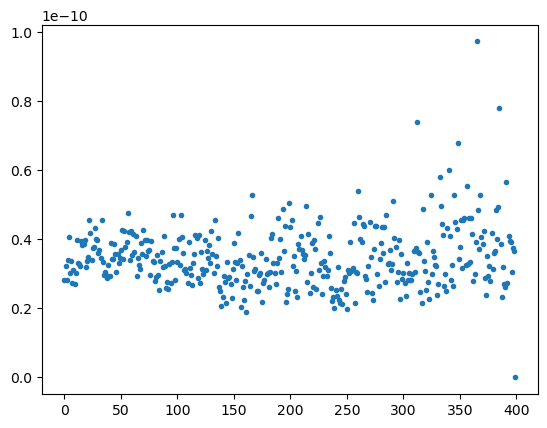

In [196]:
df['Patient 1'].plot(style = '.')

...И после

<AxesSubplot:>

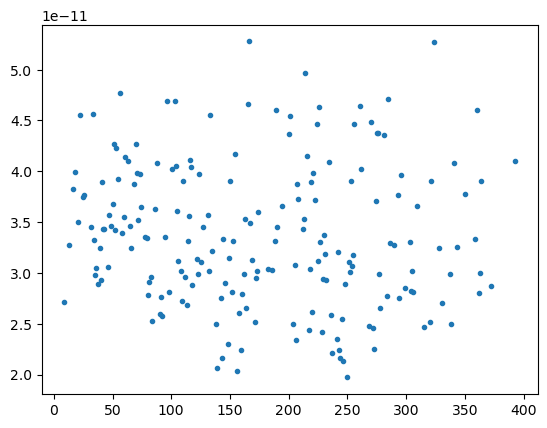

In [197]:
df_IQR['Patient 1'].plot(style = '.')

Как мы видим, экстремальные выбросы удалились из данных,а оставшиеся данные стали более близко расположенными друг к другу
(о чём свидетельствует уменьшившийся масштаб)

Следующий метод удаления выбросов - Метод Z-оценок. Как нам известно из теории вероятности:
Z-оценка — это количество стандартных отклонений от среднего значения точки данных.
Но с технической точки зрения это мера того, на сколько стандартных отклонений ниже или выше генеральной совокупности
означает необработанный результат.
Z-показатели варьируются от -3 стандартных отклонений 
(что соответствует крайнему левому углу кривой нормального распределения) до +3 стандартных отклонений
(что соответствует крайнему правому краю кривой нормального распределения)

Воспользуемся ранее сформированным DataFrame и с его помощью сформируем структуру данных не содержащую в себе выбросы,
по критерию Z-Score:

In [229]:
df_ZScore = df.copy()
patient_number = 1
for column in df_ZScore:
    patient = df_ZScore[column]
    z = np.abs(stats.zscore(patient))
    data_clean = patient[(z > 3)].index
    print('Индексы триалов для удаления Пациента №' + str(patient_number) + ': ' + ', '.join([str(x + 1) for x in data_clean]))
    patient.drop(data_clean, inplace = True)
    df_ZScore[column] = patient
    patient_number += 1

Индексы триалов для удаления Пациента №1: 313, 349, 366, 386, 400
Индексы триалов для удаления Пациента №2: 55, 184, 204, 296, 298, 337, 358, 359, 381
Индексы триалов для удаления Пациента №3: 3, 6, 9, 16, 289
Индексы триалов для удаления Пациента №4: 129, 261, 314, 315, 354, 388
Индексы триалов для удаления Пациента №5: 25, 76, 108, 185, 264, 290, 384
Индексы триалов для удаления Пациента №6: 60, 171, 184, 258, 284, 398, 399, 400
Индексы триалов для удаления Пациента №7: 204, 328
Индексы триалов для удаления Пациента №8: 2, 296, 371, 378
Индексы триалов для удаления Пациента №9: 211, 317, 318, 377
Индексы триалов для удаления Пациента №10: 131, 192, 234, 250, 260, 311
Индексы триалов для удаления Пациента №11: 21, 162, 259, 340, 345, 395
Индексы триалов для удаления Пациента №12: 76, 158, 299
Индексы триалов для удаления Пациента №13: 38, 45, 158, 169, 324, 389, 400


Снова для примера построим графики триалов для 1-го пациента данных до удаления выбросов:

<AxesSubplot:>

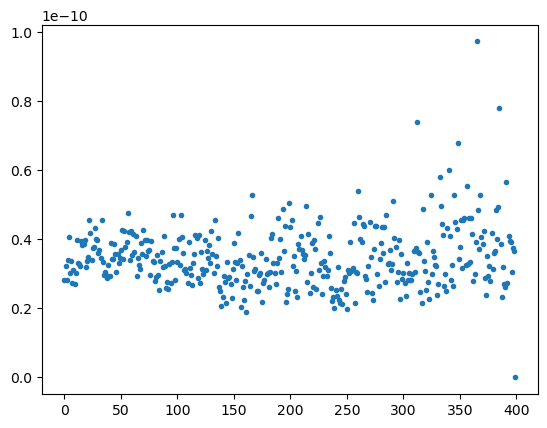

In [215]:
df['Patient 1'].plot(style = '.')

...И после:

<AxesSubplot:>

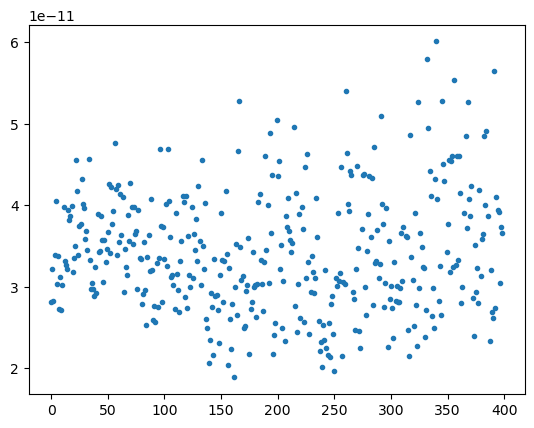

In [218]:
df_ZScore['Patient 1'].plot(style='.')

Как видно, число выбросов, которые мы удалили благодаря этому методу несколько меньше, однако результат все же достигнут.